# Import modules

In [1]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from structure_functions import *
from mean_variance import *

# import external modules
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

# Introduction

This notebook will explore the performance of the <u>mean-variance optimization</u> (MV portfolio) model compared to the <u>equal weighted portfolio</u> (EQ portfolio). In short, the notebook will follow the below Joblist.


### Joblist

1. Import return data.
2. Define initial time period.
3. Calculate initial: <br>
    3.1) Mean return. <br>
    3.2) Volatility. <br>
    3.3) Covariance matrix. <br>
4. For each period:<br>
    4.1) Return of equal weighted portfolio.<br>
    4.2) Return of MV portfolio.<br>
5. Explore weights of MV portfolio.
6. Compare results of MV and EQ portfolio
7. Explore sensitivity of MV portfolio wrt. configuration period and anchor.

# (1) Data

The data is pulled from Kennet French database ([Link](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)). Using the industry portfolios which are stocks form NYSE, AMEX, and NASDAQ put into groups of 10 to 49. Here, both monthly and daily returns are available.

In [2]:
# import data from Kennet French
df = (pdr.famafrench.FamaFrenchReader('10_Industry_Portfolios_Wout_Div', start="1900-01-01").read()[0])
#df = (pdr.famafrench.FamaFrenchReader('10_Industry_Portfolios_daily', start="1900-01-01").read()[0])

df = df.replace([-99.99, -999], 0) # replace NaN values
df = df / 100

# returns ~ column = return series
returns = df.to_numpy()

# (3-4) Calculating return of MV and EQ portfolio

This step results in three arrays being populated with 
- (1) tangency portfolio returns 
- (2) equal weighted portfolio return 
- (3) tangency portfolio weights. <br>

**Calculating realized returns**

- Estimation period: The period on which the calculation of mean, variance, and covariance is based.
- Configuration period: The period on which the initial tangency portfolio weights are calculated.

First step is to set the length of the configuration period. After setting the configuration period the next step is to set the anchor. If ```anchor=True``` the estimation period will grow from being size configuration period (when calculating $\text{weight}_0$) to being the full size of the of the time series. In other words the final weights will be based on the lenght of the full time series. If ```anchor=False``` the estimation period will simply be a rolling window of size configuration period.<br>

The tangency portfolio is calculated using the ```mean_variance``` class in codelib/mean_variance. 

In [3]:
# setting length of config period
length = 0.4889 # decimal % ~ i.e. 0.3 = 30% of full time series 

len_config_period = int(np.round(length * len(returns), 0))
len_test_period = len(returns) - len_config_period+1

# empty array for storing realized returns of MVO and EQ
realized_mv_returns = np.empty([len_test_period])
realized_eq_returns = np.empty([len_test_period])

# empty array for storing weights
mv_weights = np.empty([len_test_period, len(returns[0])])

# setting anchor
anchor = True

# loop through each time period
for period in range(0, len_test_period):
    
    # anchored period returns
    idx = len_config_period + period
    
    if anchor == False:
        anch_period_ret = returns[period:idx,:]
    elif anchor == True:
        anch_period_ret = returns[0:idx,:]
    else:
        print("anchor not set")
        
    # mvo input
    exp_return = np.mean(anch_period_ret, axis=0)
    exp_var = np.var(anch_period_ret, axis=0)
    period_cov = np.cov(anch_period_ret.T)
    
    # tangency portfolio weights
    mv = mean_variance(exp_return, exp_var, period_cov, anch_period_ret)
    tan_weights = mv.tan_port_weights(rf=0.001)
    
    # store weights
    mv_weights[period] = tan_weights
    
    # period return
    period_ret = returns[period]
    
    # store return tangency portfolio
    realized_mv_returns[period] = np.sum(tan_weights * period_ret)
    
    # store return equal weighted portfolio
    eq_weigth = 1/len(period_ret)
    realized_eq_returns[period] = np.sum(eq_weigth * period_ret)
    

# (5) Explore weights of MV portfolio



In [4]:
weight = {}

idx = 0
for asset in df.columns:
    weight[asset] = list(mv_weights[:,idx])
    idx += 1

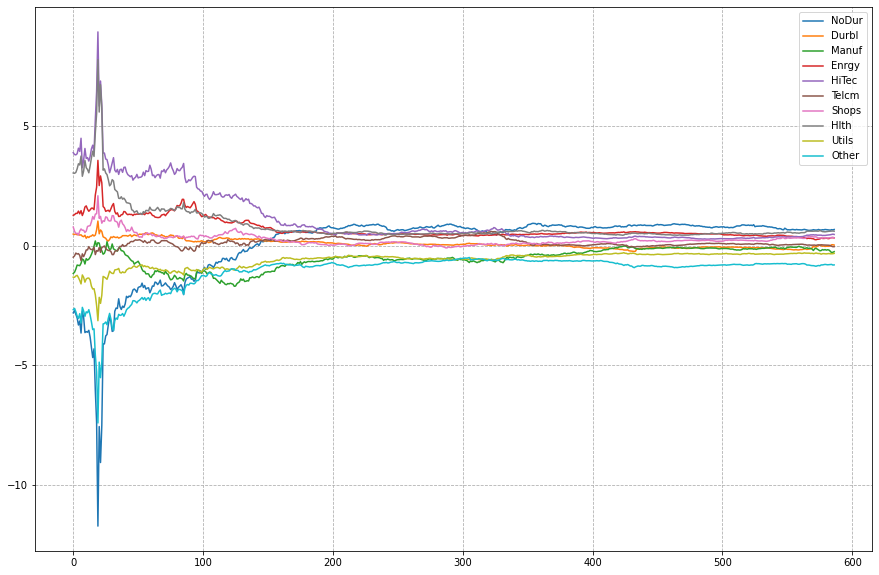

In [5]:
plt.figure(figsize=(15,10))

x = np.arange(len_test_period)

for key in weight.keys():
    plt.plot(x, weight[key], label=key)
    
plt.grid(linestyle="--")
plt.legend()
plt.show()

# (6) Compare results of portfolios

In [6]:
cum_mv = (realized_mv_returns + 1).cumprod()
cum_eq = (realized_eq_returns + 1).cumprod()

per_mv = np.round((cum_mv[-1]-1)*100,2)
per_eq = np.round((cum_eq[-1]-1)*100,2)

print("Config:", length, "%")
print("Anchor:", anchor)
print("---")
print("Cumulative return of MV:", per_mv, "%")
print("Cumulative return of EQ:", per_eq, "%")

Config: 0.4889 %
Anchor: True
---
Cumulative return of MV: 4681.15 %
Cumulative return of EQ: 793.66 %


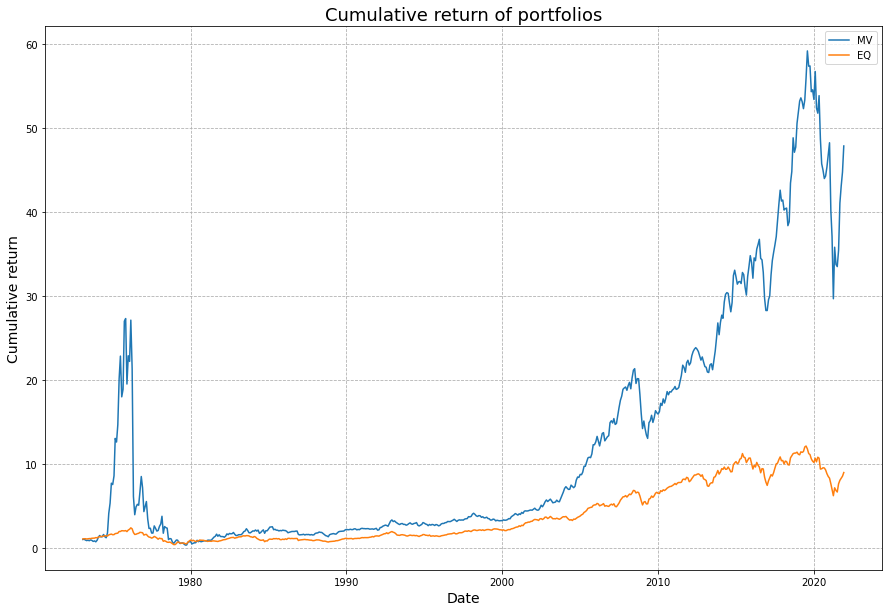

In [7]:
plt.figure(figsize=(15,10))

x = df.index[(len_config_period-1):].to_timestamp()
y = cum_mv
y1 = cum_eq

plt.plot(x, y, label="MV")
plt.plot(x, y1, label="EQ")

plt.title("Cumulative return of portfolios", size=18)
plt.ylabel("Cumulative return", size=14)
plt.xlabel("Date", size=14)

plt.grid(linestyle="--")

plt.legend()
plt.show()

# Sensitivity to length of config period and anchor state

In [8]:
anchor_lst = []
anchor_lst_eq = []
no_anchor_lst = []
no_anchor_lst_eq = []

for config_periods in np.linspace(0.1, 0.80, 10):
    
    for state in (True, False):
    
        len_config_period = int(np.round(config_periods * len(returns), 0))
        len_test_period = len(returns) - len_config_period+1

        # empty array for storing realized returns of MVO and EQ
        realized_mv_returns = np.empty([len_test_period])
        realized_eq_returns = np.empty([len_test_period])

        anchor = state
        
        for period in range(0, len_test_period):

            # anchored period returns
            idx = len_config_period + period

            if anchor == False:
                anch_period_ret = returns[period:idx,:]
            elif anchor == True:
                anch_period_ret = returns[0:idx,:]
            else:
                print("anchor not set")

            # mvo input
            exp_return = np.mean(anch_period_ret, axis=0)
            exp_var = np.var(anch_period_ret, axis=0)
            period_cov = np.cov(anch_period_ret.T)

            # tangency portfolio weights
            mv = mean_variance(exp_return, exp_var, period_cov, anch_period_ret)
            tan_weights = mv.tan_port_weights(rf=0.001)

            # period return
            period_ret = returns[period]

            # store return tangency portfolio
            realized_mv_returns[period] = np.sum(tan_weights * period_ret)

            # store return equal weighted portfolio
            eq_weigth = 1/len(period_ret)
            realized_eq_returns[period] = np.sum(eq_weigth * period_ret)
    
    
        cum_tan = (1 + realized_mv_returns).cumprod()[-1]
        cum_eq = (1 + realized_eq_returns).cumprod()[-1]
    
        if state == True:
            anchor_lst.append(cum_tan)
            anchor_lst_eq.append(cum_eq)
        elif state == False:
            no_anchor_lst.append(cum_tan)
            no_anchor_lst_eq.append(cum_eq)


pd.DataFrame({"Size of configuration period": np.round(np.linspace(0.1, 0.80, 10),4),
             "Anchor (MV)": np.round(np.array(anchor_lst),2),
             "No Anchor (MV)": np.round(np.array(no_anchor_lst),2),
             "(EQ)": np.round(np.array(no_anchor_lst_eq),2)})

,Size of configuration period,Anchor (MV),No Anchor (MV),(EQ)
0,0.1000,0.03,-0.00,214.82
1,0.1778,0.01,-2422.11,159.83
2,0.2556,-1.74,728264.26,103.42
3,0.3333,-225.14,2.02,40.67
4,0.4111,2.11,-9590057.68,15.97
5,0.4889,47.81,-3.84,8.94
6,0.5667,21.38,28.82,9.60
7,0.6444,16.35,23.39,5.17
8,0.7222,2.30,3.90,2.22
9,0.8000,1.53,2.20,1.44


**Comment**

It becomes apparent that the MV portfolio is extremely sensitive to the size of the configuration period, when anchor is not set ~ i.e. the estimation period is rolling with a size of configuration period. <br>

The EQ portfolio almosts strictly decrease in cumulative return due to the fact that the period for which return in cumulated descreases. Implying on average the assets increase over time.